In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/'My Drive'/'case study 3'

/content/gdrive/My Drive/case study 3


In [3]:
!ls

main.ipynb			Untitled1.ipynb  Untitled.ipynb
Sarcasm_Headlines_Dataset.json	Untitled2.ipynb


In [0]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer 
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
datastore = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True).drop('article_link',axis = 1)
print(datastore)
lemmatizer = WordNetLemmatizer()

                                                headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
5                            advancing the world's women             0
6         the fascinating case for eating lab-grown meat             0
7      this ceo will send your kids to school, if you...             0
8      top snake handler leaves sinking huckabee camp...             1
9      friday's morning email: inside trump's presser...             0
10     airline passengers tackle man who rushes cockp...             0
11     facebook reportedly working on healthcare feat...             0
12     north korea praises trump and urges us voters ...             0
13    

In [0]:
def tokenize(arr_s):
    "Return all words in sentence, removed all special characters"
    
    arr = []
    for s in arr_s:
        s = "something " + s + " something"
        s = re.sub(r"[^a-zA-Z]+", ' ', s)
        s = re.split(r"\s+", s)
        s = s[1:-1]
        for j in range(len(s)):
            s[j] = lemmatizer.lemmatize(s[j])
        arr.append(s)
    arr = np.array(arr)
    
    return arr

In [8]:
def GetVocabulary(str_arr):
    vocabulary = []
    sentences = tokenize(str_arr)
    
    for tokens in sentences:
        for token in tokens:
            vocabulary.append(token)
    
    vocabulary = set(vocabulary)
    vocabulary = np.array(list(vocabulary))
    return vocabulary
####################################################
vocabulary = GetVocabulary(datastore['headline'])
print(vocabulary.shape)

(21868,)


In [9]:
word2idx = {w : idx for idx, w in enumerate(vocabulary)}
print(word2idx)

{'participant': 0, 'corruption': 1, 'timoth': 2, 'bib': 3, 'existing': 4, 'incidence': 5, 'kippur': 6, 'ambitious': 7, 'polished': 8, 'counterproductive': 9, 'mane': 10, 'andy': 11, 'jew': 12, 'snyder': 13, 'toobin': 14, 'fisher': 15, 'tossing': 16, 'superhero': 17, 'accountable': 18, 'trendy': 19, 'cardiomyopathy': 20, 'hscc': 21, 'launched': 22, 'plymouth': 23, 'may': 24, 'winneshiek': 25, 'polarized': 26, 'jessica': 27, 'whiskey': 28, 'curb': 29, 'purged': 30, 'mara': 31, 'diver': 32, 'peripheral': 33, 'spouse': 34, 'consumer': 35, 'chapel': 36, 'dependent': 37, 'security': 38, 'licensed': 39, 'menswear': 40, 'achieve': 41, 'cope': 42, 'sexpot': 43, 'eclipse': 44, 'rosenstein': 45, 'malaysia': 46, 'inflatable': 47, 'signal': 48, 'danube': 49, 'techno': 50, 'telemarketers': 51, 'leaving': 52, 'impaired': 53, 'comptroller': 54, 'rumble': 55, 'worst': 56, 'captain': 57, 'lawn': 58, 'justin': 59, 'eventually': 60, 'cam': 61, 'cosby': 62, 'danced': 63, 'disease': 64, 'devastate': 65, 'do

In [10]:
def Int2Onehot(idx):
    """
    Vi du:
        idx = [1, 2, 0]   len(vocabulary) = 4
        
        --> [[0, 1, 0, 0],
             [0, 0, 1, 0],
             [1, 0, 0, 0]]
    """
    dim = len(vocabulary)
    onehot = np.zeros((len(idx), dim))
    
    onehot[range(len(idx)), idx] = 1
    
    return onehot
###
Int2Onehot([1,2, 3])

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
def words2bag(words):
    """
    Vi du : ["tuan", "huy"]   vocabulary = ["huy", "tuan", "cogiao"]
    --> idx = [1, 0]
    --> Int2Onehot(idx)
    """
    idx = np.zeros((len(words)),dtype = np.int)

    for i, word in enumerate(words):
        idx[i] = word2idx[word]
    return Int2Onehot(idx)

def docs2bag(docs):
    """
    vi du:
    ["tuan huy","tuan cogiao tuan"] vocabulary = ["huy", "tuan", "cogiao"]
    --> [[1,1,0],
         [0,2,1]]
    """
    sentences = tokenize(docs)
    
    bags = []
    
    for sentence in sentences:
        onehots = words2bag(sentence)
        bags.append(onehots.sum(axis = 0)) 
    return np.array(bags)

In [12]:
data = docs2bag(datastore['headline'])
label = np.array(datastore['is_sarcastic'])
print(data.shape, label.shape)

(26709, 21868) (26709,)


In [0]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def CELoss(output, target, mode = 'sum'):
    a = - (target * np.log(output) + (1 - target) * np.log(1 - output))
    if (mode == 'sum'):
        return a.sum()
    if (mode == 'mean'):
        return a.sum() / len(target)

class logistic():
    def fit(self, X, Y):
        self.N = X.shape[0]
        self.d = X.shape[1]
        
        ones = np.ones((self.N, 1))
        
        self.X = np.concatenate((ones, X), axis = 1)
        self.Y = Y
        
        self.w = np.random.randn(self.d + 1, 1)
        
    def predict_prob(self, X):
        one = np.ones((len(X),1))
        
        X = np.concatenate((one, X),axis = 1)
        a = X.dot(self.w)
        
        return sigmoid(a)
        
    def train(self, nepochs, batch_size, lr, lamda, print_every):
        loss = []
        for i in range(nepochs):
            mix_id = np.random.permutation(self.N)
            for j in range(0, self.N, batch_size):
                id_batch = mix_id[j : j + batch_size]
                X_batch = self.X[id_batch]                    # b * d
                Y_batch = self.Y[id_batch].reshape(-1, 1)     # b * 1
                
                Z_batch = sigmoid(X_batch.dot(self.w)).reshape(-1, 1)   # b * 1
                
                # dloss = (z - y) * x
                
                dloss = (np.multiply(Z_batch - Y_batch, X_batch).sum(axis = 0)/len(X_batch)).reshape(-1, 1)
                
                #dloss = np.ones_like(self.w)
                #for x, y, z in zip(X_batch, Y_batch, Z_batch):
                #  dloss += ((z - y) * x).reshape(-1, 1)
                  
                self.w = self.w - lr * dloss - lamda * self.w    #cập nhật w sau mỗi lần tính dloss
                
                if j % print_every ==0:
                    loss.append(CELoss(Z_batch, Y_batch, mode = 'mean'))
                    print("{}/{}  [{}/{}]  loss = {}".format(i, nepochs, j, self.N, loss[-1]))
                    
        return loss
                

In [0]:
model = logistic()
model.fit(data[:20000], label[:20000])

In [15]:
loss = model.train(100, 100, 5e-2, 1e-5, 1000)

0/100  [0/20000]  loss = 1.1684871939648347
0/100  [1000/20000]  loss = 1.4882407647428115
0/100  [2000/20000]  loss = 1.5171906139353928
0/100  [3000/20000]  loss = 1.0872209062301939
0/100  [4000/20000]  loss = 1.34586713045679
0/100  [5000/20000]  loss = 1.6026898230952933
0/100  [6000/20000]  loss = 1.4513618196308884
0/100  [7000/20000]  loss = 1.2475960072976175
0/100  [8000/20000]  loss = 1.0741253217248923
0/100  [9000/20000]  loss = 1.458585697583266
0/100  [10000/20000]  loss = 1.386185582427363
0/100  [11000/20000]  loss = 1.5307807297521336
0/100  [12000/20000]  loss = 0.8575151872447035
0/100  [13000/20000]  loss = 1.1811934096048402
0/100  [14000/20000]  loss = 1.3290554417716138
0/100  [15000/20000]  loss = 1.5432653898238378
0/100  [16000/20000]  loss = 1.4095388252053436
0/100  [17000/20000]  loss = 1.4821110010422
0/100  [18000/20000]  loss = 1.0156368287810877
0/100  [19000/20000]  loss = 0.8147245140057464
1/100  [0/20000]  loss = 1.0761803982741298
1/100  [1000/200

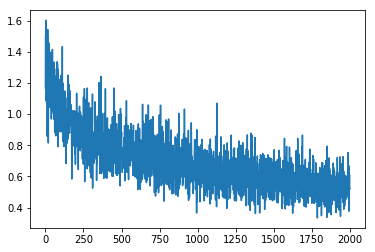

In [16]:
plt.plot(loss)

In [17]:
((model.predict_prob(data[:20000]) > 0.5).reshape(-1) == label[:20000]).sum() / len(data[:20000])

0.7652

In [18]:
((model.predict_prob(data[20000:]) > 0.5).reshape(-1) == label[20000:]).sum() / len(data[20000:])

0.7416902668057833

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [20]:
N = 20000
logreg = LogisticRegression()
logreg.fit(data[:N], label[:N])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print(label[:N])

[0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0
 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1
 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 1 1 1 1 1 0 0 1 1 0 

In [21]:
## precision = (số cái đúng) / (tổng số cái dự đoán đúng)
## recall = (số cái đúng) / số cái thực sự đúng

predict_label = logreg.predict(data[N:])
true_label = label[N:]

### Số lượng label thực sự là châm biếm trong tất cả những label dự đoán là châm biếm
true_sarcastics = 0
for i in range(len(predict_label)):
  if (predict_label[i] == 1 and predict_label[i] == true_label[i]):
    true_sarcastics += 1
    
### Số lượng label là châm biếm trong tổng số tất cả label
relevant_sarcastics = true_label.sum()


### Số lượng label dự đoán là đúng
predicted_sarcastics = predict_label.sum()
# for i in predicted:
#     if (i == labelx):
#         predicted_x += 1

precision = true_sarcastics / predicted_sarcastics
recall = true_sarcastics / relevant_sarcastics
print(precision, recall)

0.8319598710139735 0.7924914675767918


In [0]:
def recall(predict_label : list, true_label : list, label : int):
  true_positive = 0
  for i in range(len(predict_label)):
    if (predict_label[i] == label and predict_label[i] == true_label[i]):
      true_positive += 1

  relevant_elements = 0
  for i in range(len(predict_label)):
    if (true_label[i] == label):
      relevant_elements += 1
  
  return true_positive / relevant_elements

def precision(predict_label : list, true_label : list, label : int):
  true_positive = 0
  for i in range(len(predict_label)):
    if (predict_label[i] == label and predict_label[i] == true_label[i]):
      true_positive += 1

  positive = 0
  for i in range (len (predict_label)):
    if (predict_label[i] == label):
      positive += 1
  
  return true_positive / positive

def f1_score(predict_label : list, true_label : list, label : int):
  precision_score = precision(predict_label, true_label, label)
  recall_score = recall(predict_label, true_label, label)
  
  f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score)
  
  return f1

In [23]:
sarcastic = 1
non_sarcastic = 0

print("Sarcastic...........precision = {}   recall = {}".format(precision(predict_label, true_label, sarcastic), recall(predict_label, true_label, sarcastic)))
print("Non_Sarcastic.......precision = {}   recall = {}".format(precision(predict_label, true_label, non_sarcastic), recall(predict_label, true_label, non_sarcastic)))

Sarcastic...........precision = 0.8319598710139735   recall = 0.7924914675767918
Non_Sarcastic.......precision = 0.844818785094436   recall = 0.8758930934109552


In [24]:
print("Sarcastic...........f1 score = {}".format(f1_score(predict_label, true_label, sarcastic)))
print("NoneSarcastic.......f1 score = {}".format(f1_score(predict_label, true_label, non_sarcastic)))

Sarcastic...........f1 score = 0.8117461982170949
NoneSarcastic.......f1 score = 0.8600753540340392


In [0]:
# dữ liệu về thẻ atm giả mạo.
# số lượng thẻ giả mạo là rất ít. Trong dữ liệu, phải 100 000 thẻ thật mới có một thẻ giả mạo
# nếu đưa dữ liệu vào mô hình ML sử dụng hàm đánh giá accuracy. Mô hình này chỉ cần luôn trả về kết quả là 
# .. thẻ thật thì nó chính xác đến 99.999%
# Ta cần một hàm đánh giá mà, cho ta biết tỉ lệ dự đoán một thẻ là thẻ giả mạo trên tổng số thẻ giả mạo là cao nhất có thể
# --> recall

# Dữ liệu và thư spam
# Số lượng thư spam là rất ít.
# Ta muốn mô hình thà dự đoán sai còn hơn là dự đoán một thư bình thường là spam

In [0]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(predict_label, true_label)
print(average_precision)

0.7292271954334298


In [0]:
# dữ liệu giả theo dữ liệu atm (1 - thật, 0 - giả)
real = 1
fake = 0
predict_y = [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
true_y    = [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
print(precision(predict_y, true_y, real), recall(predict_y, true_y, real))
print(precision(predict_y, true_y, fake), recall(predict_y, true_y, fake))


0.8333333333333334 0.9090909090909091
0.5 0.3333333333333333


In [0]:
# dữ liệu giả theo dữ liệu thư spam (1 - spam, 0 - bình thường)
spam = 1
normal = 0
predict_y = [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
true_y    = [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
print(precision(predict_y, true_y, spam), recall(predict_y, true_y, spam))
print(precision(predict_y, true_y, normal ), recall(predict_y, true_y, normal))


0.3333333333333333 0.5
0.9090909090909091 0.8333333333333334
